In [1]:
from __future__ import annotations
import jax
import jax.numpy as jnp

import pyhf
import matplotlib.pyplot as plt

from model import make_model
import relaxed

import jaxopt
import optax


pyhf.set_backend("jax", default=True)


def metrics(
    model: pyhf.Model,
    observed_data: jnp.array,
    diff_pars: jnp.ndarray,
) -> jnp.array:
    cls_obs, bestfit_pars = relaxed.hypotest(
        1.0, observed_data, model, init_pars=jnp.array([0.0, 0.0]), return_mle_pars=True
    )
    cov_approx = relaxed.fisher_info_covariance(bestfit_pars, model, observed_data)
    mu_idx, y_idx = model.config.par_order.index("mu"), model.config.par_order.index(
        "bkguncrt"
    )
    mu_uncert2 = cov_approx[mu_idx, mu_idx]
    pull_width_metric2 = (1 - cov_approx[y_idx, y_idx]) ** 2
    gaussianity = relaxed.model_gaussianity(
        model, bestfit_pars, cov_approx, observed_data
    )

    return dict(
        cls_obs=cls_obs,
        mu_uncert2=mu_uncert2,
        pull_width_metric2=pull_width_metric2,
        gaussianity=gaussianity,
    )


def pipeline(pars: jnp.array, data: jnp.array) -> jnp.array:
    model = make_model(pars)
    all_data = jnp.concatenate((data, jnp.array(model.config.auxdata)))
    return jnp.array(list(metrics(model, all_data, pars).values()))

In [16]:
jax.jacrev(pipeline)(jnp.array([-2.0, -2.0]), data=jnp.array([50.0, 50]))

DeviceArray([[ 0.        ,  0.        ],
             [ 0.        ,  0.        ],
             [ 0.        ,  0.        ],
             [-0.01130129, -0.0269187 ]], dtype=float64)

In [2]:
def loss(pars):
    #     return jnp.sum(pipeline(pars, jnp.array([50.,50.]))*scale)
    return pipeline(pars, jnp.array([50.0, 50.0]))[0]


jax.value_and_grad(loss)(jnp.array([1.0, 1.0]))

KeyboardInterrupt: 

In [3]:
import time

params = jnp.array([-4.432, 2.0])

tx = optax.sgd(learning_rate=100)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

for i in range(50):
    t0 = time.perf_counter()
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    t1 = time.perf_counter()
    print(f"in {t1-t0:.3f}s, loss step {i}: {loss_val:.4f}, pars = {params}")

in 22.520s, loss step 0: 0.2421, pars = [-4.17089996  1.33085459]
in 22.642s, loss step 1: 0.2374, pars = [-3.9178368   0.77940539]
in 22.487s, loss step 2: 0.2340, pars = [-3.68202162  0.32947027]
in 22.820s, loss step 3: 0.2316, pars = [-3.46747136 -0.03848772]
in 23.393s, loss step 4: 0.2299, pars = [-3.27509584 -0.34121352]
in 24.008s, loss step 5: 0.2287, pars = [-3.1042178  -0.59186685]
in 23.886s, loss step 6: 0.2279, pars = [-2.95341555 -0.80060292]
in 23.208s, loss step 7: 0.2273, pars = [-2.82095932 -0.97528519]
in 23.454s, loss step 8: 0.2268, pars = [-2.7050407 -1.1220699]
in 23.352s, loss step 9: 0.2265, pars = [-2.6038895  -1.24583327]
in 23.440s, loss step 10: 0.2263, pars = [-2.51583372 -1.350481  ]
in 23.434s, loss step 11: 0.2261, pars = [-2.43932998 -1.43917453]
in 24.060s, loss step 12: 0.2260, pars = [-2.37297322 -1.51449374]
in 23.335s, loss step 13: 0.2259, pars = [-2.3155001  -1.57856204]
in 24.094s, loss step 14: 0.2258, pars = [-2.2657821  -1.63313633]
in 24.1

In [ ]:
[-4.17089996  1.33085459]
[-3.9178368   0.77940539]
[-3.68202162  0.32947027]
[-3.46747136 -0.03848772]
[-3.27509584 -0.34121352]
[-3.1042178  -0.59186685]
 [-2.95341555 -0.80060292]
[-2.82095932 -0.97528519]
[-2.7050407 -1.1220699]
[-2.6038895  -1.24583327]
in 23.440s, loss step 10: 0.2263, pars = [-2.51583372 -1.350481  ]
in 23.434s, loss step 11: 0.2261, pars = [-2.43932998 -1.43917453]
in 24.060s, loss step 12: 0.2260, pars = [-2.37297322 -1.51449374]
in 23.335s, loss step 13: 0.2259, pars = [-2.3155001  -1.57856204]
in 24.094s, loss step 14: 0.2258, pars = [-2.2657821  -1.63313633]
in 24.130s, loss step 15: 0.2258, pars = [-2.22281711 -1.67967761]
in 23.461s, loss step 16: 0.2257, pars = [-2.18572091 -1.71940762]
in 23.477s, loss step 17: 0.2257, pars = [-2.15371723 -1.75335262]
in 24.300s, loss step 18: 0.2257, pars = [-2.12612504 -1.78237555]
in 24.131s, loss step 19: 0.2257, pars = [-2.10234973 -1.80720521]
in 23.990s, loss step 20: 0.2256, pars = [-2.08187261 -1.82845776]
in 25.151s, loss step 21: 0.2256, pars = [-2.06424471 -1.84665781]
in 24.025s, loss step 22: 0.2256, pars = [-2.04907468 -1.86224926]
in 24.083s, loss step 23: 0.2256, pars = [-2.03602376 -1.87561022]
in 24.089s, loss step 24: 0.2256, pars = [-2.02479974 -1.88706376]
in 23.951s, loss step 25: 0.2256, pars = [-2.01514855 -1.89688395]
in 24.229s, loss step 26: 0.2256, pars = [-2.00685164 -1.90530562]
in 23.563s, loss step 27: 0.2256, pars = [-1.99971931 -1.91252832]
in 23.823s, loss step 28: 0.2256, pars = [-1.99358995 -1.91872462]
in 24.554s, loss step 29: 0.2256, pars = [-1.98832281 -1.9240407 ]
in 24.784s, loss step 30: 0.2256, pars = [-1.9837971 -1.9286021]
in 24.126s, loss step 31: 0.2256, pars = [-1.97990942 -1.93251694]

In [126]:
import numpy as np

dense = 8
num_up, num_down = (dense, dense)

up_grid = np.linspace(-10, 10, num_up)
down_grid = np.linspace(-10, 10, num_down)

uv, dv = np.meshgrid(up_grid, down_grid)

In [127]:
pipe = partial(pipeline, data=jnp.array([50.0, 50.0]))
values = np.array([pipe(jnp.array(a)) for a in np.vstack([uv.ravel(), dv.ravel()]).T])

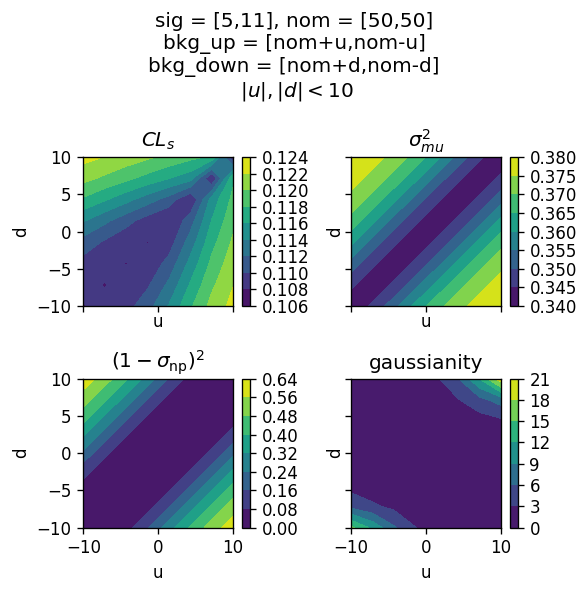

In [128]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=[5, 5], dpi=120, facecolor="w")

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i, (label, ax) in enumerate(
    zip(
        ["$CL_s$", r"$\sigma_{mu}^2$", r"$(1-\sigma_{\mathsf{np}})^2$", "gaussianity"],
        axs.ravel(),
    )
):
    p = ax.contourf(uv, dv, values[:, i].reshape((dense, dense)))
    plt.colorbar(p, ax=ax)
    ax.set_xlabel("u")
    ax.set_ylabel("d")
    ax.set_title(label)

plt.suptitle(
    "sig = [5,11], nom = [50,50]\nbkg_up = [nom+u,nom-u]\nbkg_down = [nom+d,nom-d]\n $|u|, |d|<10$"
)
plt.tight_layout()